In [1]:
"""
Purpose: To test the visualizations 
of just takig the average of node features

Psueodocode: 
1) Get the all batch data
2) Average across all of the batches
3) Plot with the given labels

"""

'\nPurpose: To test the visualizations \nof just takig the average of node features\n\nPsueodocode: \n1) Get the all batch data\n2) Average across all of the batches\n3) Plot with the given labels\n\n'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/meshAfterParty")
sys.path.append("/datasci_tools/datasci_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/graph_tools/graph_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")
sys.path.append("/pytorch_tools/pytorch_tools/")

import datajoint_utils as du
from importlib import reload

WARNING - 2022-05-06 10:30:27,838 - _default - No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Using default Google credentials. There is no ~/.cloudvolume/secrets/google-secret.json set.


INFO - 2022-05-06 10:30:29,795 - settings - Setting enable_python_native_blobs to True
INFO - 2022-05-06 10:30:29,797 - settings - Setting stores to {'h01_skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/skeletons', 'stage': '/mnt/dj-stor01/microns/h01/skeletons'}, 'h01_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/meshes', 'stage': '/mnt/dj-stor01/microns/h01/meshes'}, 'h01_faces': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/faces', 'stage': '/mnt/dj-stor01/microns/h01/faces'}, 'h01_decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/decimated_meshes', 'stage': '/mnt/dj-stor01/microns/h01/decimated_meshes'}, 'h01_soma_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/soma_meshes', 'stage': '/mnt/dj-stor01/microns/h01/soma_meshes'}}
INFO - 2022-05-06 10:30:29,807 - connection - Connected celiib@at-database.ad.bcm.edu:3306


Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2022-05-06 10:30:30,875 - settings - Setting enable_python_native_blobs to True
WARNING - 2022-05-06 10:30:34,553 - utils - DataJointPlus version check failed.
INFO - 2022-05-06 10:30:36,180 - settings - Setting enable_python_native_blobs to True
ERROR - 2022-05-06 10:30:36,202 - compatibility - Could not add DataJointPlus to ImportMethod.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info_from_header
    if result[0] == attr:
IndexError: list index out of range
ERROR - 2022-05-06 10:30:36,250 - compatibility - Could not add DataJointPlus to Materialization.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info

In [4]:
from microns_morphology_api.schemas import minnie65_morphology as m65mor
m65mor.config.register_adapters(context=locals())
m65mor.config.register_externals()

from microns_morphology_api.schemas import minnie65_auto_proofreading as m65auto
m65auto.config.register_adapters(context=locals())
m65auto.config.register_externals()

In [5]:
from dataInterfaceMinnie65 import data_interface as hdju

In [6]:
import neuron_nx_utils as nxu
import networkx_utils as xu
import morphopy_utils as mpu

In [7]:
import dimensionality_reduction_ml as dru
import preprocessing_ml as preml
import pandas_ml as pdml
import pandas_utils as pu
import visualizations_ml as vml
import system_utils as su

In [8]:
#datasci_tools modules
import system_utils as su
import pandas_utils as pu
import pandas as pd
import numpy as np
import numpy_utils as nu
import networkx_utils as xu
from tqdm_utils import tqdm

#neuron_morphology_tools modules
import neuron_nx_io as nxio

# Loading the Data

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cpu


In [11]:
with_skeleton = False

features_to_delete = [
    "mesh_volume",
    "apical_label",
    "basal_label",
]

if not with_skeleton:
    features_to_delete +=[
        "skeleton_vector_downstream_phi",      
        "skeleton_vector_downstream_theta",    
        "skeleton_vector_upstream_phi",        
        "skeleton_vector_upstream_theta",  
    ]

features_to_keep = None

In [12]:
import system_utils as su
gnn_task = "cell_type_fine"
graph_label = "cell_type_fine_label"
data_file = "df_morphometrics.pbz2"
data_path = "./data/m65_full/"

data_filepath = Path(data_path) / Path(data_file)

data_df = su.decompress_pickle(data_filepath)
data_df

segment_id  split_index  nucleus_id external_layer  \
0      864691134277239760            0       89719        LAYER_6   
1      864691134339067925            0      624899        LAYER_6   
2      864691134366116139            0      476756   WHITE_MATTER   
3      864691134378215335            0        3799      LAYER_2/3   
4      864691134527727930            0      631380   WHITE_MATTER   
...                   ...          ...         ...            ...   
65211  864691137197345345            0      584463      LAYER_2/3   
65212  864691137197345601            0      493570        LAYER_5   
65213  864691137197345601            1      533074        LAYER_5   
65214  864691137197353281            0      591241        LAYER_5   
65215  864691137197364801            0      488097      LAYER_2/3   

      external_visual_area                                     cell_type_fine  \
0                       V1  {'normalized depth': 0.1, 'dendrite branch poi...   
1                       AL  {'normalized depth': 0.1, 'dendrite branch poi...   
2                       RL  {'normalized depth': 0.1, 'axon branch points'...   
3                       V1  {'normalized depth': 0.1, 'dendrite branch poi...   
4                       RL  {'normalized depth': 0.1, 'dendrite branch poi...   
...                    ...                                                ...   
65211                   RL  {'normalized depth': 0.1, 'axon branch points'...   
65212                   RL  {'normalized depth': 0.1, 'axon branch points'...   
65213                   RL  {'normalized depth': 0.1, 'axon branch points'...   
65214                   RL  {'normalized depth': 0.1, 'axon branch points'...   
65215                   RL  {'normalized depth': 0.1, 'axon branch points'...   

      cell_type_fine_label  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
...                    ...  
65211                  NaN  
65212                  NaN  
65213                  NaN  
65214                  NaN  
65215                  NaN  

[65216 rows x 7 columns]

In [33]:
import pandas as pd
morpho_df = pd.DataFrame.from_records(data_df[gnn_task].to_list())
y_list = data_df[graph_label].to_list()
label_name = "cell_type_fine_label"
morpho_df[label_name] = y_list
morpho_df

ValueError: Length of values (65216) does not match length of index (50101)

In [29]:
id_cols = ["segment_id","split_index","nucleus_id"]
cell_type_cols = ["cell_type_fine_label",]#"cell_type_coarse","table_of_origin"]
meta_data_cols = id_cols + cell_type_cols
bcm_features = [k for k in mpu.exc_features_berenslab if "apical" not in k]
data_cols = bcm_features
df_cell_type_stats_filt = morpho_df[data_cols + [label_name]]
df_cell_type_stats_filt

dendrite bifurcation standard deviation  dendrite branch points  \
0                                          NaN                     0.0   
1                                     0.000000                     1.0   
2                                          NaN                     0.0   
3                                     0.000000                     1.0   
4                                          NaN                     0.0   
...                                        ...                     ...   
65211                                82.169432                    31.0   
65212                               119.720139                    36.0   
65213                               165.802299                     9.0   
65214                                14.103478                    43.0   
65215                                26.223829                    20.0   

       dendrite first bifurcation moment  dendrite height  \
0                                    NaN             3.11   
1                               1.950000             3.85   
2                                    NaN             2.44   
3                               2.660000             4.28   
4                                    NaN             2.72   
...                                  ...              ...   
65211                          50.971034           404.55   
65212                          52.314483           463.49   
65213                          86.235000           608.98   
65214                           4.111163           188.71   
65215                           7.732500           158.96   

       dendrite log max tortuosity  dendrite log min tortuosity  \
0                         0.426326                     0.426326   
1                         0.090295                     0.000670   
2                         0.169220                     0.169220   
3                         0.014546                     0.000000   
4                         0.341337                     0.341337   
...                            ...                          ...   
65211                     2.075277                     0.000000   
65212                     5.935429                     0.000000   
65213                     0.505592                     0.000000   
65214                     0.453799                     0.000000   
65215                     0.591774                     0.000000   

       dendrite max Euclidean dist  dendrite max branch order  \
0                         5.445962                        0.0   
1                         5.263183                        1.0   
2                         6.018347                        0.0   
3                         4.659893                        1.0   
4                         6.159172                        0.0   
...                            ...                        ...   
65211                   281.151242                       10.0   
65212                   379.782741                        9.0   
65213                   529.802926                        4.0   
65214                   140.947625                        8.0   
65215                   101.059362                        7.0   

       dendrite max path distance to soma  dendrite max segment length  ...  \
0                                8.341142                     8.341142  ...   
1                                9.950452                     6.736058  ...   
2                                7.128013                     7.128013  ...   
3                                6.771507                     4.321620  ...   
4                                8.664888                     8.664888  ...   
...                                   ...                          ...  ...   
65211                          439.378928                   244.447099  ...   
65212                          693.452791                   215.899561  ...   
65213                          612.451037                   386.551483  ...   
65214    

In [30]:
import pandas_utils as pu
keep_idx = pu.find_all_rows_without_nan(df_cell_type_stats_filt)
df_no_nan = df_cell_type_stats_filt.iloc[keep_idx,:]
df_no_nan

dendrite bifurcation standard deviation  dendrite branch points  \
128                                 114.315884                    21.0   
160                                  16.925189                    22.0   
183                                  88.115086                    20.0   
220                                  25.752487                    17.0   
228                                  17.787033                    14.0   
...                                        ...                     ...   
65171                                10.813547                    12.0   
65173                                21.963581                    20.0   
65191                                19.027690                    12.0   
65202                                23.435103                    18.0   
65206                                74.667170                    12.0   

       dendrite first bifurcation moment  dendrite height  \
128                            51.379524           473.08   
160                            -3.298889           338.90   
183                            68.312778           371.17   
220                             9.052143           513.40   
228                            10.891429           135.17   
...                                  ...              ...   
65171                           1.159000           373.59   
65173                           4.808947           151.59   
65191                           5.590000           558.32   
65202                          12.049375           343.87   
65206                          34.014167           315.26   

       dendrite log max tortuosity  dendrite log min tortuosity  \
128                       0.290004                     0.008740   
160                       0.377764                     0.001619   
183                       0.682446                     0.004303   
220                       0.306815                     0.005450   
228                       1.818577                     0.021084   
...                            ...                          ...   
65171                     0.305752                     0.000000   
65173                     0.580632                     0.001714   
65191                     0.205164                     0.000000   
65202                     2.014913                     0.000000   
65206                     0.424772                     0.006916   

       dendrite max Euclidean dist  dendrite max branch order  \
128                     383.569084                        5.0   
160                     259.432957                        6.0   
183                     319.937713                       10.0   
220                     291.786004                        7.0   
228                     170.001265                        5.0   
...                            ...                        ...   
65171                   269.591249                        4.0   
65173                   222.216304                        5.0   
65191                   433.883224                        5.0   
65202                   245.465073                        7.0   
65206                   248.477488                        5.0   

       dendrite max path distance to soma  dendrite max segment length  ...  \
128                            414.945328                   286.509324  ...   
160                            307.049413                   246.444654  ...   
183                            354.581606                   120.828785  ...   
220                            700.762945                   285.792913  ...   
228                            266.550761                    92.706209  ...   
...                                   ...                          ...  ...   
65171                          654.147590                   245.497496  ...   
65173                          244.655790                   162.931291  ...   
65191                         1275.264249                   371.101440  ...   
65202    

In [31]:
target_name="cell_type_fine_label"
df_no_nan = df_no_nan.query(f"{target_name}=={target_name}")

dendrite bifurcation standard deviation  dendrite branch points  \
128                                 114.315884                    21.0   
160                                  16.925189                    22.0   
183                                  88.115086                    20.0   
220                                  25.752487                    17.0   
228                                  17.787033                    14.0   
...                                        ...                     ...   
65171                                10.813547                    12.0   
65173                                21.963581                    20.0   
65191                                19.027690                    12.0   
65202                                23.435103                    18.0   
65206                                74.667170                    12.0   

       dendrite first bifurcation moment  dendrite height  \
128                            51.379524           473.08   
160                            -3.298889           338.90   
183                            68.312778           371.17   
220                             9.052143           513.40   
228                            10.891429           135.17   
...                                  ...              ...   
65171                           1.159000           373.59   
65173                           4.808947           151.59   
65191                           5.590000           558.32   
65202                          12.049375           343.87   
65206                          34.014167           315.26   

       dendrite log max tortuosity  dendrite log min tortuosity  \
128                       0.290004                     0.008740   
160                       0.377764                     0.001619   
183                       0.682446                     0.004303   
220                       0.306815                     0.005450   
228                       1.818577                     0.021084   
...                            ...                          ...   
65171                     0.305752                     0.000000   
65173                     0.580632                     0.001714   
65191                     0.205164                     0.000000   
65202                     2.014913                     0.000000   
65206                     0.424772                     0.006916   

       dendrite max Euclidean dist  dendrite max branch order  \
128                     383.569084                        5.0   
160                     259.432957                        6.0   
183                     319.937713                       10.0   
220                     291.786004                        7.0   
228                     170.001265                        5.0   
...                            ...                        ...   
65171                   269.591249                        4.0   
65173                   222.216304                        5.0   
65191                   433.883224                        5.0   
65202                   245.465073                        7.0   
65206                   248.477488                        5.0   

       dendrite max path distance to soma  dendrite max segment length  ...  \
128                            414.945328                   286.509324  ...   
160                            307.049413                   246.444654  ...   
183                            354.581606                   120.828785  ...   
220                            700.762945                   285.792913  ...   
228                            266.550761                    92.706209  ...   
...                                   ...                          ...  ...   
65171                          654.147590                   245.497496  ...   
65173                          244.655790                   162.931291  ...   
65191                         1275.264249                   371.101440  ...   
65202    

In [35]:
df_no_nan = pu.filter_away_non_finite_rows(df_no_nan)
df_no_nan

dendrite bifurcation standard deviation  dendrite branch points  \
128                                 114.315884                    21.0   
160                                  16.925189                    22.0   
183                                  88.115086                    20.0   
220                                  25.752487                    17.0   
228                                  17.787033                    14.0   
...                                        ...                     ...   
65171                                10.813547                    12.0   
65173                                21.963581                    20.0   
65191                                19.027690                    12.0   
65202                                23.435103                    18.0   
65206                                74.667170                    12.0   

       dendrite first bifurcation moment  dendrite height  \
128                            51.379524           473.08   
160                            -3.298889           338.90   
183                            68.312778           371.17   
220                             9.052143           513.40   
228                            10.891429           135.17   
...                                  ...              ...   
65171                           1.159000           373.59   
65173                           4.808947           151.59   
65191                           5.590000           558.32   
65202                          12.049375           343.87   
65206                          34.014167           315.26   

       dendrite log max tortuosity  dendrite log min tortuosity  \
128                       0.290004                     0.008740   
160                       0.377764                     0.001619   
183                       0.682446                     0.004303   
220                       0.306815                     0.005450   
228                       1.818577                     0.021084   
...                            ...                          ...   
65171                     0.305752                     0.000000   
65173                     0.580632                     0.001714   
65191                     0.205164                     0.000000   
65202                     2.014913                     0.000000   
65206                     0.424772                     0.006916   

       dendrite max Euclidean dist  dendrite max branch order  \
128                     383.569084                        5.0   
160                     259.432957                        6.0   
183                     319.937713                       10.0   
220                     291.786004                        7.0   
228                     170.001265                        5.0   
...                            ...                        ...   
65171                   269.591249                        4.0   
65173                   222.216304                        5.0   
65191                   433.883224                        5.0   
65202                   245.465073                        7.0   
65206                   248.477488                        5.0   

       dendrite max path distance to soma  dendrite max segment length  ...  \
128                            414.945328                   286.509324  ...   
160                            307.049413                   246.444654  ...   
183                            354.581606                   120.828785  ...   
220                            700.762945                   285.792913  ...   
228                            266.550761                    92.706209  ...   
...                                   ...                          ...  ...   
65171                          654.147590                   245.497496  ...   
65173                          244.655790                   162.931291  ...   
65191                         1275.264249                   371.101440  ...   
65202    

In [36]:
import preprocessing_ml as preml
df_no_nan = pu.filter_away_non_finite_rows(df_no_nan)
df_scaled = preml.scale_df(df_no_nan,target_name=target_name)
data_cols = [k for k in df_scaled if k != label_name and k not in features_to_delete]
df_scaled = df_scaled[data_cols + [target_name]]
df_scaled

dendrite bifurcation standard deviation  dendrite branch points  \
0                                    1.235970               -0.232905   
1                                   -1.069675               -0.147176   
2                                    0.615688               -0.318635   
3                                   -0.860696               -0.575823   
4                                   -1.049271               -0.833011   
...                                       ...                     ...   
3416                                -1.214363               -1.004469   
3417                                -0.950395               -0.318635   
3418                                -1.019900               -1.004469   
3419                                -0.915558               -0.490093   
3420                                 0.297320               -1.004469   

      dendrite first bifurcation moment  dendrite height  \
0                              0.691717         0.683097   
1                             -1.013943        -0.272113   
2                              1.219940        -0.042387   
3                             -0.628660         0.970129   
4                             -0.571285        -1.722441   
...                                 ...              ...   
3416                          -0.874882        -0.025160   
3417                          -0.761024        -1.605549   
3418                          -0.736659         1.289909   
3419                          -0.535163        -0.236733   
3420                           0.150015        -0.440404   

      dendrite log max tortuosity  dendrite log min tortuosity  \
0                       -0.386554                     1.688785   
1                       -0.329091                    -0.115829   
2                       -0.129595                     0.564414   
3                       -0.375547                     0.855113   
4                        0.614307                     4.816625   
...                           ...                          ...   
3416                    -0.376243                    -0.526059   
3417                    -0.196260                    -0.091688   
3418                    -0.442105                    -0.526059   
3419                     0.742862                    -0.526059   
3420                    -0.298312                     1.226373   

      dendrite max Euclidean dist  dendrite max branch order  \
0                        0.650029                  -0.858492   
1                       -0.387195                  -0.552565   
2                        0.118355                   0.671144   
3                       -0.116868                  -0.246638   
4                       -1.134445                  -0.858492   
...                           ...                        ...   
3416                    -0.302317                  -1.164419   
3417                    -0.698160                  -0.858492   
3418                     1.070430                  -0.858492   
3419                    -0.503904                  -0.246638   
3420                    -0.478734                  -0.858492   

      dendrite max path distance to soma  dendrite max segment length  ...  \
0                              -0.157699                     0.797871  ...   
1                              -0.586597                     0.348549  ...   
2                              -0.397651                    -1.060223  ...   
3                               0.978459                     0.789836  ...   
4                              -0.747584                    -1.375615  ...   
...                                  ...                          ...  ...   
3416                            0.793158                     0.337927  ...   
3417                           -0.834619                    -0.588047  ...   
3418                            3.262167                     1.746565  ...   
3419                            0.388411                     0.264

In [37]:
# -- mapping of the labels to integers --
total_labels,label_counts = np.unique((data_df.query(f"{graph_label}=={graph_label}")[
    graph_label]).to_numpy(),return_counts = True)
cell_type_map = {k:i+1 for i,k in enumerate(total_labels)}
cell_type_map[None] = 0
cell_type_map

{'1P': 1,
 '23P': 2,
 '4P': 3,
 '5P_IT': 4,
 '5P_NP': 5,
 '5P_PT': 6,
 '6CT': 7,
 '6P': 8,
 '6P_CT': 9,
 '6P_IT': 10,
 '6P_U': 11,
 'BC': 12,
 'BPC': 13,
 'I targeting non_bpc': 14,
 'IT_big_tuft': 15,
 'IT_short': 16,
 'IT_small_tuft': 17,
 'Martinotti': 18,
 'NGC': 19,
 'Pvalb': 20,
 'SST': 21,
 'Unsure': 22,
 'VIP': 23,
 'WM_P': 24,
 'cb1 basket': 25,
 'chandelier': 26,
 'l1vip': 27,
 'ndnf+npy_': 28,
 'ngfc': 29,
 'prox targeting': 30,
 'small basket': 31,
 None: 0}

In [38]:
#cell_type_map
cell_type_fine_classifier_weights = {
'23P': 0.25,#1294
'4P': 0.3,#890
'5P_IT': 0.5,#465
'6P': 0.8,#342
'6P_IT': 0.8,#263
'5P_PT': 0.8,#224
}


class_idx = np.array(list(cell_type_map.values()) )
class_labels = np.array(list(cell_type_map.keys()) )
weights = np.array([cell_type_fine_classifier_weights.get(k,1) for k in class_labels])
weights = weights[np.argsort(class_idx)]
weights

array([1.  , 1.  , 0.25, 0.3 , 0.5 , 1.  , 0.8 , 1.  , 0.8 , 1.  , 0.8 ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

# Creating the Custom Dataset

In [39]:
from torch.utils.data import Dataset, DataLoader
import torch

In [40]:
class MyDataset(Dataset):
    def __init__(self,):
        
        X,y = pdml.X_y(df_scaled,target_name="cell_type_fine_label")
        
        x=X.to_numpy().astype("float")
        y=y.to_numpy()
        
        y_int = [int(cell_type_map[k]) for k in y]

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y_int,dtype=torch.long)

    def __len__(self):
        return len(self.y_train)
  
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]
    
    @property
    def num_features(self):
        return self.x_train.shape[1]
    @property
    def num_classes(self):
        return np.max(np.unique(self.y_train)) + 1

In [41]:
dataset = MyDataset()

In [42]:
dataset_num_node_features = dataset.num_features
dataset_num_classes = dataset.num_classes

In [43]:
import preprocessing_utils as pret
batch_size = 64

(train_dataset,
val_dataset,
test_dataset,) = pret.train_val_test_split(
    dataset,
    return_dict=False,
    verbose = True)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

test size = 684.0 (0.2 %)
validation size = 684.0 (0.2 %)
train_size = 2053.0
data_lengths_with_train = [2053  684  684]
Number of training graphs: 2053
Number of test graphs: 684
Number of val graphs: 684


# Picking the Model

In [44]:
n_epochs = 300

import evaluation_utils as evu
import torch.nn.functional as F
import model_utils as mdlu
verbose = True

In [45]:
import geometric_models as gm

model_name = "ClassifierFlat"

model = getattr(gm,model_name)(
    n_inputs=dataset_num_node_features,
    n_classes=dataset_num_classes,
    softmax=True
)

# Training the Model

In [46]:
optimizer_kwargs = dict(
    lr=0.01)

run_kwargs = optimizer_kwargs

In [47]:
optimizer = torch.optim.Adam(model.parameters(), **optimizer_kwargs)
print(model)



# ---------------- Configuring the Tensorboard and Checkpoinns--------------------
from torch.utils.tensorboard import SummaryWriter

tensorboard_dir = Path("./tensorboard")
tensorboard_dir.mkdir(exist_ok=True)
tensorboard_dir = tensorboard_dir / Path(f"{model_name}")
tensorboard_dir.mkdir(exist_ok=True)

tensorboard_file_name = (f'{model_name}_' 
                         + "_".join([f"{k}_{v}" for k,v in run_kwargs.items()]))
tensorboard_file_name += f"_with_skeleton_{with_skeleton}"
print(f"tensorboard_file_name = {tensorboard_file_name}")
tensorboard_file = tensorboard_dir / Path(f'{tensorboard_file_name}')
try:
    su.rm_dir(tensorboard_file)
except:
    pass
tensorboard_file.mkdir(exist_ok = True)


#-- when to save a checkpoint of the model
checkpoint_dir = Path("./model_checkpoints")
checkpoint_dir.mkdir(exist_ok = True)
checkpoint_dir = checkpoint_dir / Path(f"{model_name}")
checkpoint_dir.mkdir(exist_ok = True)
checkpoint_path = checkpoint_dir / Path(f"./{tensorboard_file_name}_checkpoints")

try:
    su.rm_dir(checkpoint_path)
except:
    pass

checkpoint_path.mkdir(exist_ok = True)
n_epoch_for_checkpoint = 5

writer = SummaryWriter(tensorboard_file)


print(model)


# weights = weight#[0.1,0.5,,1,0.7,1,1,1]
# class_weights = None
class_weights = torch.FloatTensor(weights).to(device)

tensor_map = None

def train():
    model.train()

    for data in train_loader:#train_loader:  # Iterate in batches over the training dataset.
        #print(f"data = {data}")
        X,y = data
        X = X.to(device)
        y = y.to(device)
        if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
        elif model_name == "TreeLSTM":
            n = data.x.shape[0]
            h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
            c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
            out = model(
                data,
                h = h,
                c = c,
                embeddings = data.x
                )
        else:
            out = model(X)
        y_true = y.squeeze_()
        #print(f"out.shape = {out.shape}, data.y.shape = {data.y.shape}")
        loss = F.nll_loss(
            torch.log(out), y_true,
            weight = class_weights,
        )  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        return loss


def test(loader,verbose = False):
    model.eval()
    y_pred_list = []
    y_true_list = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        X,y = data
        X = X.to(device)
        y = y.to(device)
        if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
        elif model_name == "TreeLSTM":
            n = data.x.shape[0]
            h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
            c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
            out = model(
                data,
                h = h,
                c = c,
                embeddings = data.x
                )
        else:
            out = model(X)

        y_pred = out.argmax(dim=1)  # Use the class with highest probability.
        y_true = y.squeeze_()
        y_pred_list.append(y_pred)
        y_true_list.append(y_true)
#         error_idx = np.where(pred > 0)[0]
#         if len(error_idx) > 0:
#             print(f"error_idx = {error_idx}")
    y_pred = torch.cat(y_pred_list)
    y_true = torch.cat(y_true_list)

    return evu.metric_dict(
        y_true,
        y_pred,
        tensor_map=tensor_map,
        metrics=["accuracy"],
    )

log_to_tensorboard = True
for epoch in range(0, n_epochs):
    loss = train()
    writer.add_scalar('loss',loss,epoch) # new line
    train_metric_dict = test(train_loader)#train_loader)
    val_metric_dict = test(val_loader)#test_loader)

    if epoch % n_epoch_for_checkpoint == 0 and epoch != 0:
        val_acc = val_metric_dict['accuracy'].numpy()
        checkpoitn_filepath = checkpoint_path / Path(f"{tensorboard_file_name}_epoch_{epoch}")#_val_acc_{val_acc:.2f}")
        print(f"Saving off checkpoint {checkpoitn_filepath}")
        mdlu.save_checkpoint(model,filepath = checkpoitn_filepath,epoch = epoch,loss = loss)


    print(f'Epoch: {epoch:03d}, loss = {loss}')
    for type_name,metric_dict in zip(["train","val"],[train_metric_dict,val_metric_dict]):
        print_log = f"   {type_name} metrics: "
        for k,v in metric_dict.items():
            if log_to_tensorboard:
                writer.add_scalar(f'{type_name}_{k}',v,epoch)
            print_log += f" {k}: {v:4f},"

        print(print_log)

    if val_metric_dict["accuracy"] < 0.0001:
        break

ClassifierFlat(
  (lin): Linear(in_features=26, out_features=32, bias=True)
)
tensorboard_file_name = ClassifierFlat_lr_0.01_with_skeleton_False
ClassifierFlat(
  (lin): Linear(in_features=26, out_features=32, bias=True)
)
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31],y_pred_counts = [ 18  25 139  43  60  89  15 122  30  43 139 140  40 213  13  18 120  35
  15  17  71  27   3 237 105 100  34  30  45  61   6]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 0  1  2  3  4  5  6  7  8  9 10 11 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 16 18 19 21 23 24 25 27 28 29 30],y_pred_counts = [  2 481 259 167   6 198  13  81 160 203   3 122 311   3   9   3   2   1
   3   2   4   2  15   3]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  6  7  8  9 10 12 13 16 18 19 24 29],y_pred_counts = [165  85  47  73   7  28  60  62  36 107   3   4   2   1   4]
Epoch: 009, loss = 3.1262803077697754
   train metrics:  accuracy: 0.354116,
   val metrics:  accuracy: 0.353801,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 16 18 22],y_pred_counts = [175 125  46   1  72  72  35  35  35  85   1   1   1]
Epoch: 018, loss = 2.8501369953155518
   train metrics:  accuracy: 0.440331,
   val metrics:  accuracy: 0.435673,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22 24 29],y_pred_counts = [523 384 144   4 192 234  88 104 115 251   3   4   5   2]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22 24],y_pred_counts = [572 464 148  36 157 289  52  76 132 112   4   9   2]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22],y_pred_counts = [177 165  47  15  64  96  16  18  35  46   2   3]
Epoch: 028, loss = 2.5112109184265137
   train metrics:  accuracy: 0.514369,
   val metrics:  accuracy: 0.497076,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22 24],y_pred_counts = [601 480 165  55 127 258  51  96 107  76  22  13   2]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22],y_pred_counts = [187 170  49  21  55  84  24  26  33  25   6   4]
Epoch: 038, loss = 2.624791145324707
   train metrics:  accuracy: 0.543108,
   val metrics:  accuracy: 0.527778,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  5

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 16 18 22 24],y_pred_counts = [558 518 178  46 117 266  24 119  89  50   1   1  69  16   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22],y_pred_counts = [180 178  55  17  53  93   8  37  26  13  18   6]
Epoch: 052, loss = 2.275822639465332
   train metrics:  accuracy: 0.554311,
   val metrics:  accuracy: 0.540936,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 16 18 22 24],y_pred_counts = [535 533 158  51 109 276  55 102  63  54   6   2 100   8   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 22],y_pred_counts = [172 182  50  21  53  94  15  30  20  13   1  30   3]
Epoch: 062, loss = 2.210808277130127
   train metrics:  accuracy: 0.556746,
   val metrics:  accuracy: 0.539474,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 16 18 21 22],y_pred_counts = [170 178  53  23  52  90  19  42  20  11   1  23   1   1]
Epoch: 071, loss = 2.5064938068389893
   train metrics:  accuracy: 0.564540,
   val metrics:  accuracy: 0.548246,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 16 18 21 22],y_pred_counts = [531 542 160  54 108 261  72 134  68  41   2   1  75   2   2]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21],y_pred_counts = [516 558 165  53 111 265  57 127  94  46  59   2]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 16 18 21 22],y_pred_counts = [171 175  51  25  52  95  14  42  26  15   1  15   1   1]
Saving off checkpoint model_checkpoints/ClassifierFlat/ClassifierFlat_lr_0.01_with_skeleton_False_checkpoints/ClassifierFlat_lr_0.01_with_skeleton_False_epoch_85
Epoch: 085, loss = 2.289863348007202
   train metrics:  accuracy: 0.571359,
   val metrics:  accuracy: 0.552632,
  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [173 187  53  21  48  88  11  43  24  19  14   1   2]
Epoch: 094, loss = 2.4627625942230225
   train metrics:  accuracy: 0.569898,
   val metrics:  accuracy: 0.559942,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 17 18 21],y_pred_counts = [510 586 180  46 108 237  43 132  95  63   1  49   3]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 17 18 21 22],y_pred_counts = [525 577 150  50 101 143 122 160  87  60   6   2  62   4   4]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 21 22],y_pred_counts = [177 189  48  20  45  40  44  59  22  17   3  15   1   4]
Epoch: 108, loss = 2.039639472961426
   train metrics:  accuracy: 0.580127,
   val metrics:  accuracy: 0.554094,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 15 17 18 21 22],y_pred_counts = [543 585 138  51 107 102 143 183  80  52   3   1   1  19  43   2]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [185 183  48  21  48  32  47  64  20  15   9   9   3]
Epoch: 122, loss = 1.7453616857528687
   train metrics:  accuracy: 0.572333,
   val metrics:  accuracy: 0.565789,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21],y_pred_counts = [530 574 159  54 100 202  69 159  77  51  65  13]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [180 179  55  22  46  58  31  55  17  18  17   4   2]
Epoch: 132, loss = 1.961930751800537
   train metrics:  accuracy: 0.588894,
   val metrics:  accuracy: 0.564327,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  5

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 11 12 13 15 18 21 24],y_pred_counts = [552 545 170  51 105 262  48 118   1  74  57   2  63   4   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [188 166  57  21  46  82  21  42  20  20  17   2   2]
Epoch: 146, loss = 2.158795118331909
   train metrics:  accuracy: 0.595714,
   val metrics:  accuracy: 0.564327,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 22 24],y_pred_counts = [566 524 185  40 109 273  32 134  75  58   1  53   2   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [185 165  60  19  47  94  12  41  22  20  17   1   1]
Saving off checkpoint model_checkpoints/ClassifierFlat/ClassifierFlat_lr_0.01_with_skeleton_False_checkpoints/ClassifierFlat_lr_0.01_with_skeleton_False_epoch_160
Epoch: 160, loss = 1.777287244796753
   train metrics:  accuracy: 0.585485,
   val metrics:  accuracy: 0.56

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 21],y_pred_counts = [540 542 187  40 102 269  26 142  93  49   1  56   6]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [186 167  65  19  47  89   7  45  25  14  18   1   1]
Saving off checkpoint model_checkpoints/ClassifierFlat/ClassifierFlat_lr_0.01_with_skeleton_False_checkpoints/ClassifierFlat_lr_0.01_with_skeleton_False_epoch_170
Epoch: 170, loss = 2.0659492015838623
   train metrics:  accuracy: 0.586459,
   val metrics:  accuracy: 0.555556,


   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 21],y_pred_counts = [511 574 193  40 100 281  17 128 110  50   1  43   5]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [173 180  65  18  45  97   3  40  28  16  17   1   1]
Saving off checkpoint model_checkpoints/ClassifierFlat/ClassifierFlat_lr_0.01_with_skeleton_False_checkpoints/ClassifierFlat_lr_0.01_with_skeleton_False_epoch_180
Epoch: 180, loss = 1.8572027683258057
   train metrics:  accuracy: 0.588407,
   val metrics:  accuracy: 0.571637,


   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 21 24],y_pred_counts = [505 600 165  40  99 286  11 133 104  54   6  48   1   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 16 18 22 24],y_pred_counts = [169 194  58  16  45  95   2  42  27  14   2   1  17   1   1]
Epoch: 194, loss = 2.0812392234802246
   train metrics:  accuracy: 0.587433,
   val metrics:  accuracy: 0.565789,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 17 18 19 21],y_pred_counts = [544 553 166  44  96 292   5 138  89  55   6   2  60   1   2]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 15 18 22 24],y_pred_counts = [178 187  53  19  44  97  45  25  14   2  18   1   1]
Epoch: 204, loss = 2.019242286682129
   train metrics:  accuracy: 0.600097,
   val metrics:  accuracy: 0.565789,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [197 165  69  22  44  83   2  43  22  22  13   1   1]
Epoch: 213, loss = 1.5562955141067505
   train metrics:  accuracy: 0.603020,
   val metrics:  accuracy: 0.573099,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 19 21],y_pred_counts = [598 503 207  45  95 246  22 135  82  63   1  52   1   3]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 15 18 19 21 23],y_pred_counts = [619 484 232  38  98 178  62 133  82  74   1   1  44   2   4   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [202 155  79  19  46  56  21  42  21  28  13   1   1]
Epoch: 223, loss = 1.8804171085357666
   train metrics:  accuracy: 0.595714,
   val metrics:  accuracy: 0.557018,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [198 169  64  16  46  48  45  34  23  27  12   1   1]
Epoch: 232, loss = 1.9448697566986084
   train metrics:  accuracy: 0.590843,
   val metrics:  accuracy: 0.561404,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 11 12 13 15 16 17 18 19 21 22 23],y_pred_counts = [600 518 194  40  97 178 101 107   2  86  75   2   2   1  36   1   2  10
   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 11 12 13 15 16 17 18 21 22 23],y_pred_counts = [578 563 181  51  97 217  75  85   1  89  70   2   2   4  25   3   9   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 16 18 22],y_pred_counts = [188 183  62  22  46  72  24  25  24  26   1  10   1]
Epoch: 242, loss = 1.8469492197036743
   train metrics:  accuracy: 0.589381,
   val metrics:  accuracy: 0.565789,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 16 17 18 19 21 22],y_pred_counts = [574 550 239  44  94 249   7  98  96  61   2   3  30   1   1   4]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 16 18 21 22],y_pred_counts = [187 177  75  19  45  85   2  28  26  24   1  12   1   2]
Epoch: 252, loss = 2.1235289573669434
   train metrics:  accuracy: 0.587920,
   val metrics:  accuracy: 0.571637,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 45

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 16 17 18 19 21],y_pred_counts = [565 543 246  34  95 228  25 114  98  56   3   2  40   1   3]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 16 18 21 22],y_pred_counts = [184 176  76  14  45  75  12  36  30  21   1   2  10   1   1]
Epoch: 262, loss = 1.8738044500350952
   train metrics:  accuracy: 0.590843,
   val metrics:  accuracy: 0.564327,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 45

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 16 17 18 21],y_pred_counts = [566 549 200  35  97 207  54 153  89  57   2   1  42   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 16 18 21],y_pred_counts = [187 176  71  13  45  64  18  54  22  20   2  11   1]
Epoch: 272, loss = 1.690756916999817
   train metrics:  accuracy: 0.597662,
   val metrics:  accuracy: 0.571637,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 16 17 18 21],y_pred_counts = [551 560 157  33 100 219  61 172  67  73   1   2   2  54   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [183 176  61  13  47  70  19  57  15  25  18]
Epoch: 282, loss = 1.7875257730484009
   train metrics:  accuracy: 0.595714,
   val metrics:  accuracy: 0.571637,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 11

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82  11 150  65 115  15  55  43   8  18  24  19  41
  10   3  21  15   6   8   2   1   5   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 16 18 21 22 29],y_pred_counts = [542 590 170  35  99 221  52 143  71  59   5   2  55   1   7   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 29 31],y_true_counts = [  5 197 147  70  21  33   8  52  15  41   2  11  15   1   6   6   9  18
   2   3   9   5   2   4   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22],y_pred_counts = [183 183  64  16  45  69  19  50  16  21  17   1]
Epoch: 292, loss = 1.9911810159683228
   train metrics:  accuracy: 0.603020,
   val metrics:  accuracy: 0.580409,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30],y_true_counts = [  6 609 457 217  43  82 

# Testing the Data

In [48]:
all_data_loader = DataLoader(dataset, batch_size=batch_size,shuffle = False)
all_data_loader

In [49]:
model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    X,y = data
    X = X.to(device)
    y = y.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(X)

    out_array = out.detach().cpu().numpy()
    out_labels = y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

  0%|          | 0/54 [00:00<?, ?it/s]

In [50]:
np.unique(embedding_df["cell_type"].to_numpy(),return_counts=True)

(array(['1P', '23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6CT', '6P', '6P_CT',
        '6P_IT', '6P_U', 'BC', 'BPC', 'I targeting non_bpc', 'IT_big_tuft',
        'IT_short', 'IT_small_tuft', 'Martinotti', 'NGC', 'Pvalb', 'SST',
        'Unsure', 'VIP', 'WM_P', 'cb1 basket', 'chandelier', 'l1vip',
        'ndnf+npy_', 'ngfc', 'prox targeting', 'small basket'],
       dtype=object),
 array([  13, 1005,  741,  367,   74,  149,   23,  257,  105,  200,   20,
          84,   69,   14,   29,   33,   32,   78,   14,    6,   41,   22,
           9,   13,    2,    1,    3,    7,    8,    1,    1]))

In [51]:
labeled_idx = embedding_df.query("cell_type != 'Unknown'").index.to_numpy()
labeled_mask_plotting = np.zeros(len(embedding_df))
labeled_mask_plotting[labeled_idx] = 1
labeled_mask_plotting = labeled_mask_plotting.astype("bool")
labeled_mask_plotting

array([ True,  True,  True, ...,  True,  True,  True])

# Step 6: Plotting Embeddings

In [52]:
%matplotlib inline
import visualizations_ml as vml
n_components = 3
import dimensionality_reduction_ml as dru

In [53]:
import pandas_ml as pdml
X_data,y_labels = pdml.X_y(embedding_df,"cell_type")

In [54]:
X = X_data[labeled_mask_plotting].to_numpy().astype("float")
y = y_labels[labeled_mask_plotting].to_numpy()

In [55]:
X_input=X[y!= "Unsure"]
y_input = y[y != "Unsure"]

# Prep) PCA Preprocessing

<Figure size 432x288 with 0 Axes>

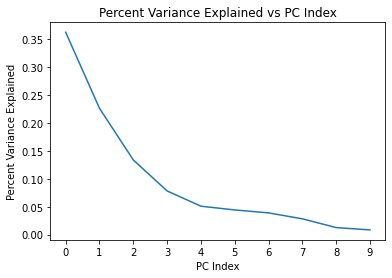

In [56]:
n_components_test=10
pca_data = dru.pca_analysis(
    X,
    n_components=n_components_test,
    plot_sqrt_eigvals=False,
    plot_perc_variance_explained=True
)

X_pca = pca_data["data_proj"]

# a) PCA

In [57]:
sys.path.append('/meshAfterParty/meshAfterParty/')
import datajoint_utils as du
import cell_type_utils as ctu

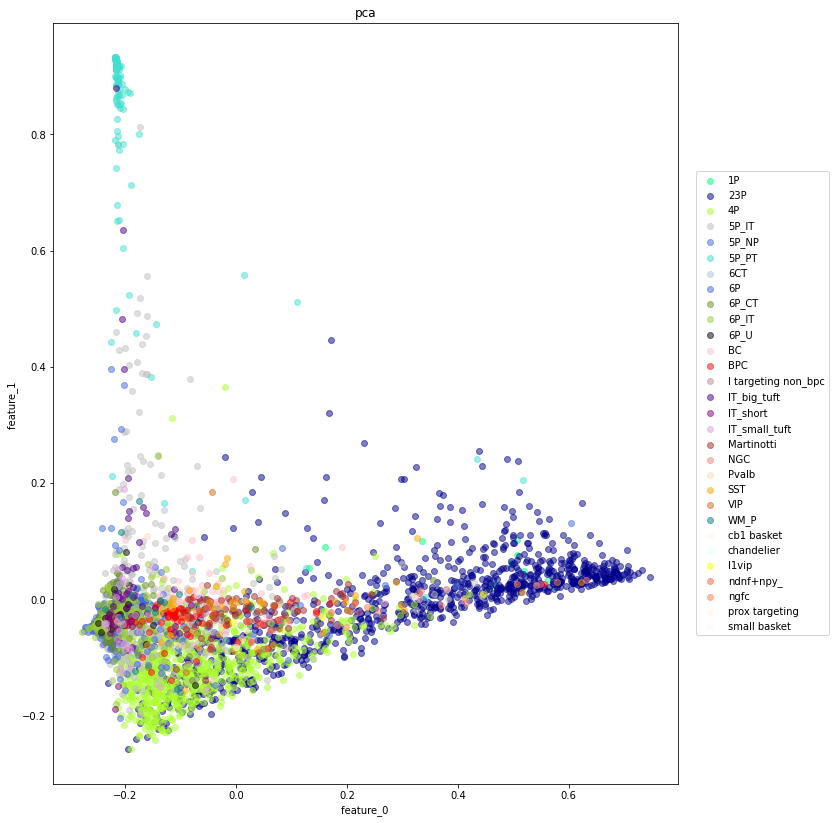

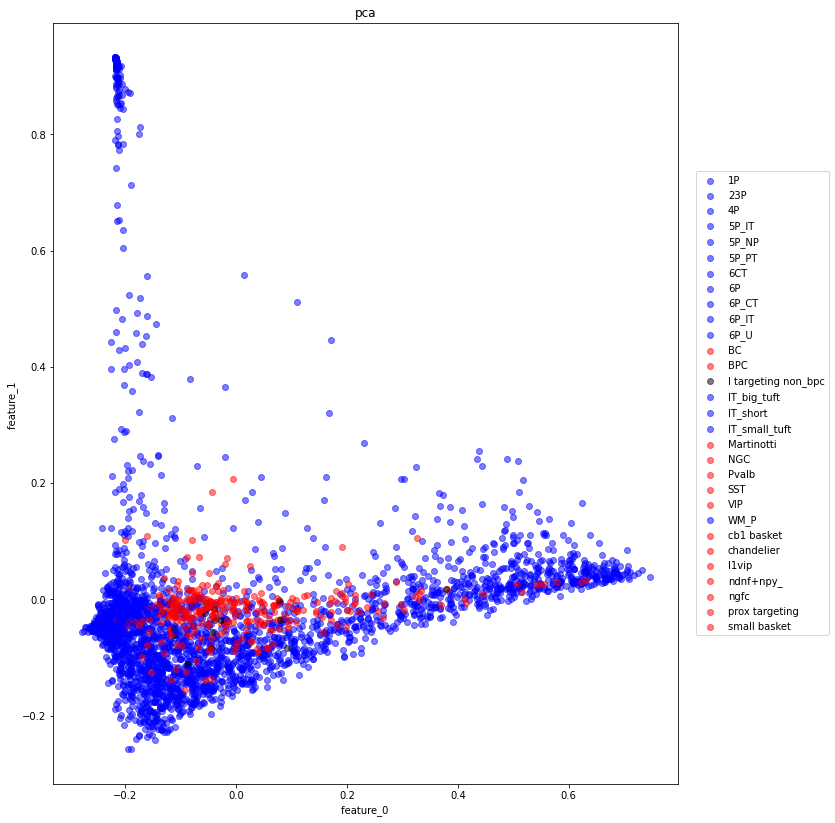

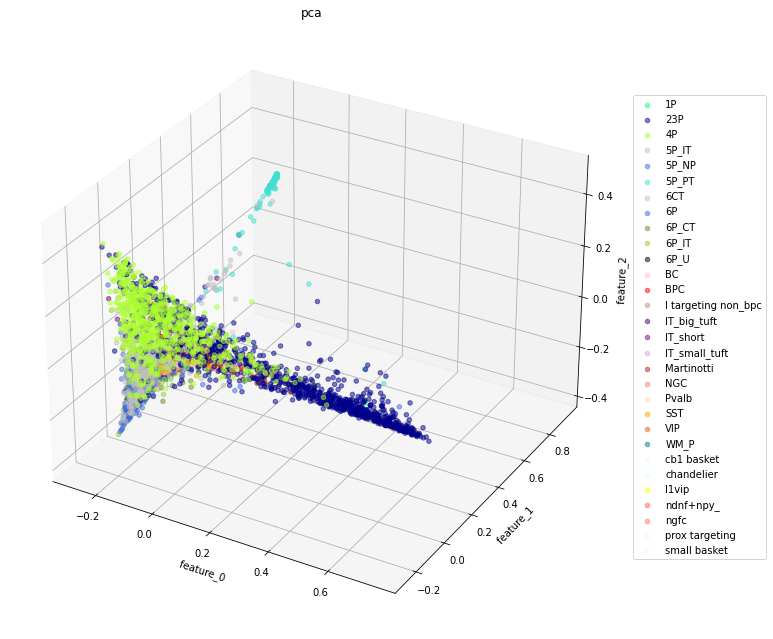

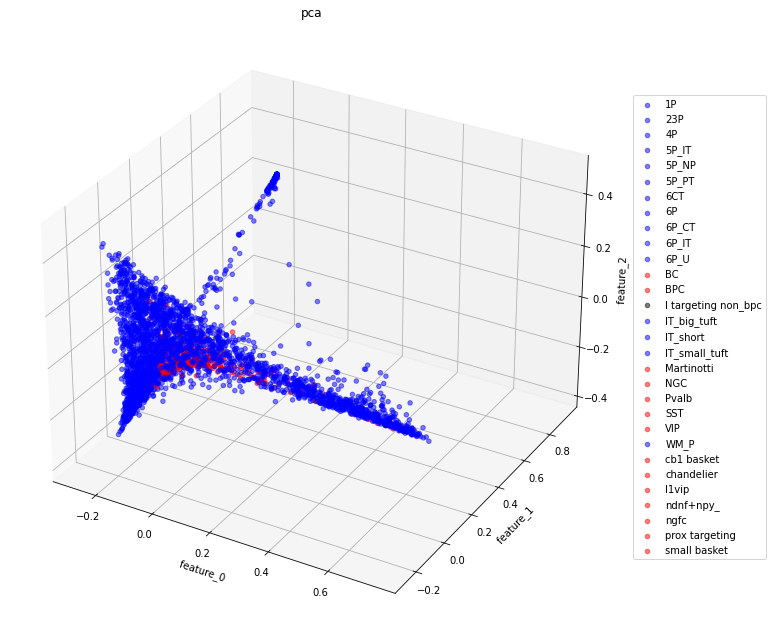

In [58]:
import dimensionality_reduction_ml as dru
import cell_type_utils as ctu
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "pca",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
)

# b) UMAP (0.5)

In [59]:
X_trans = dru.dimensionality_reduction_by_method(
        method="UMAP",
        X = X_input,
        n_components =2,
        min_dist = 0.5,
        )

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9100. The TBB threading layer is disabled.
  warnings.warn(problem)


In [60]:
method = "UMAP"

<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

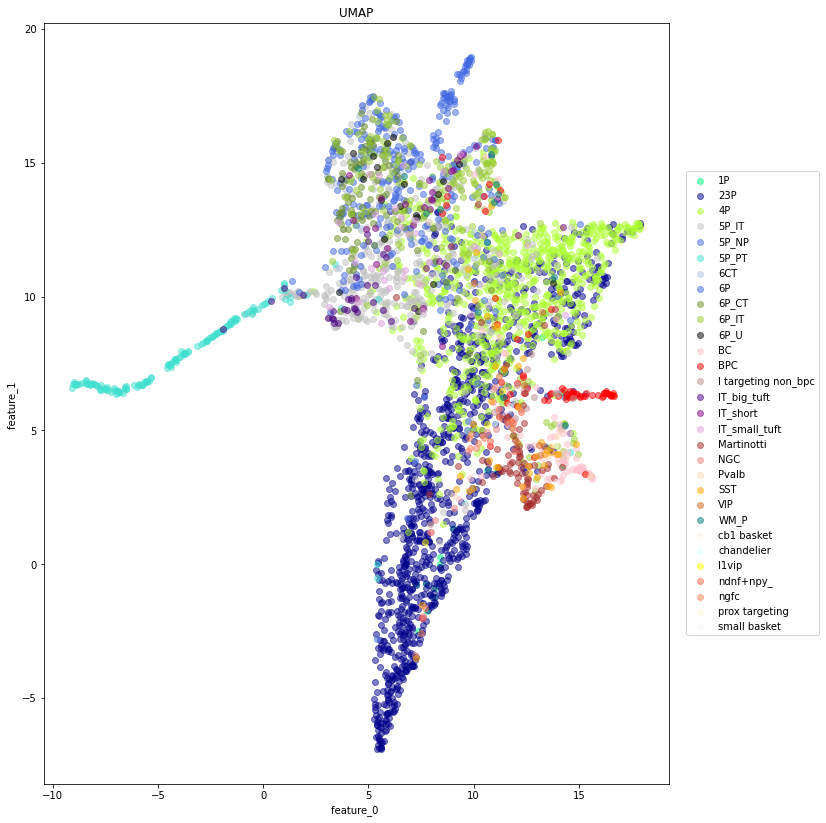

In [61]:
vml.plot_df_scatter_classification(
                X = X_trans,
                y = y_input,
                target_to_color = ctu.cell_type_fine_color_map,
                ndim = 2,
                title=method,
            )

<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

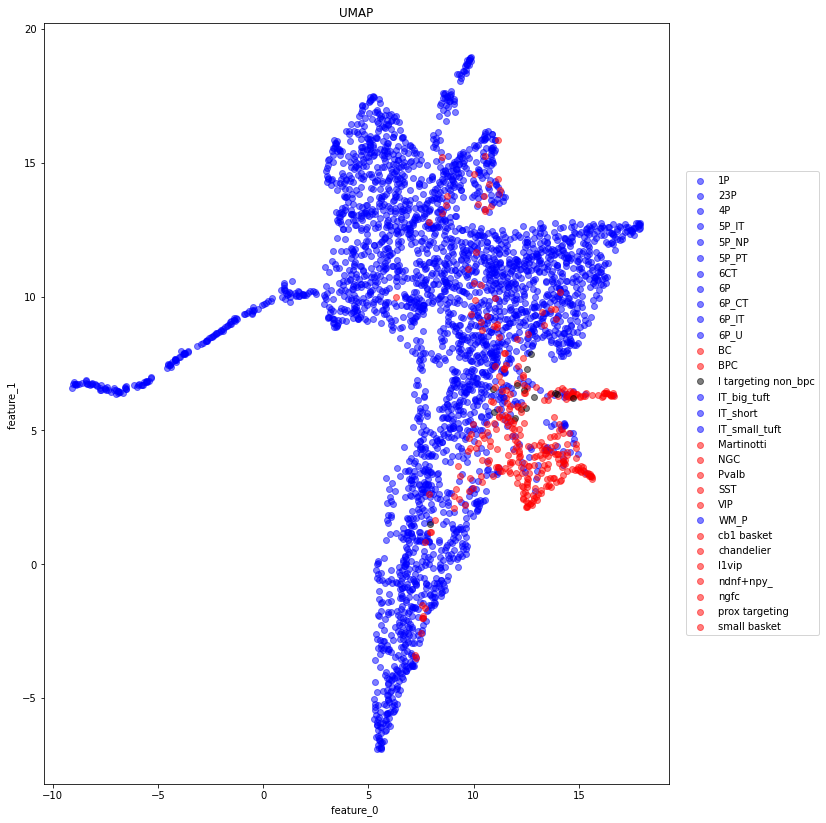

In [62]:
vml.plot_df_scatter_classification(
                X = X_trans,
                y = y_input,
                target_to_color = ctu.e_i_color_dict(),
                ndim = 2,
                title=method,
            )

<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

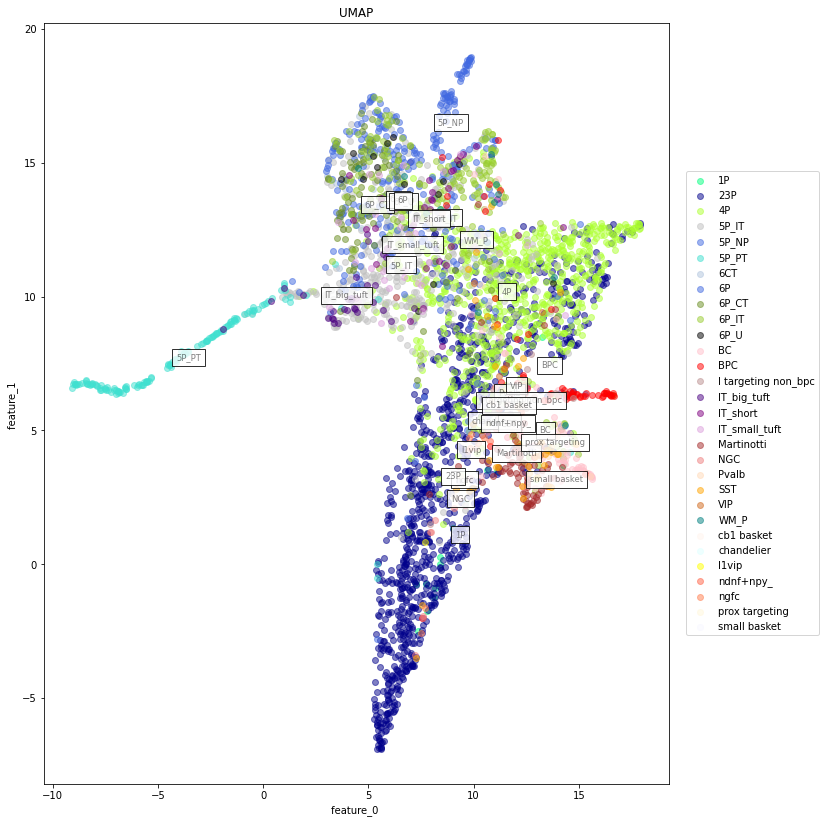

In [63]:
vml.plot_df_scatter_classification(
                X = X_trans,
                y = y_input,
                target_to_color = ctu.cell_type_fine_color_map,
                ndim = 2,
                title=method,
    use_labels_as_text_to_plot=True
            )

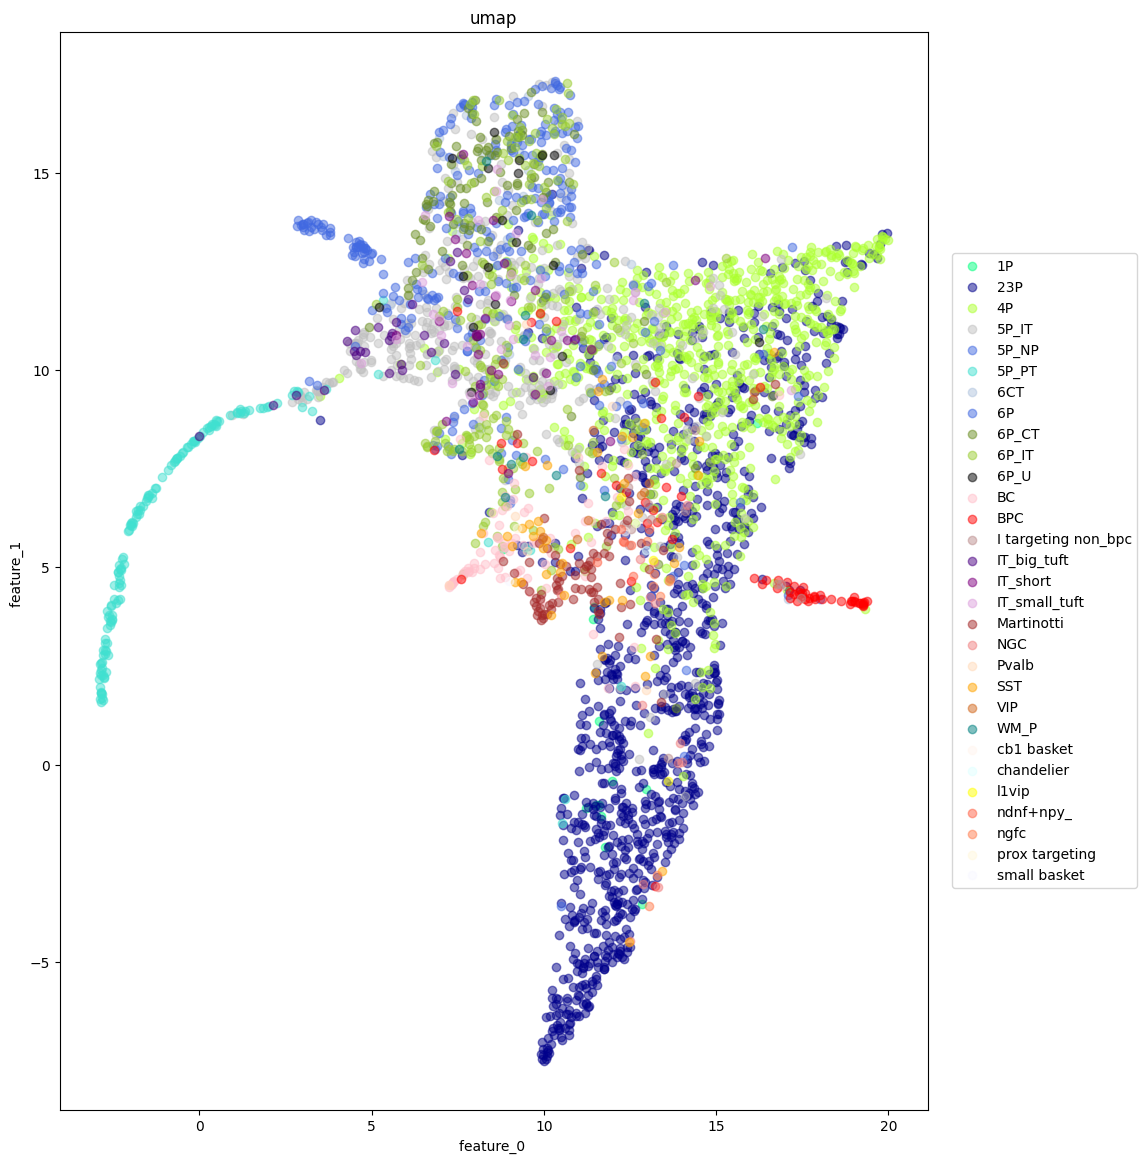

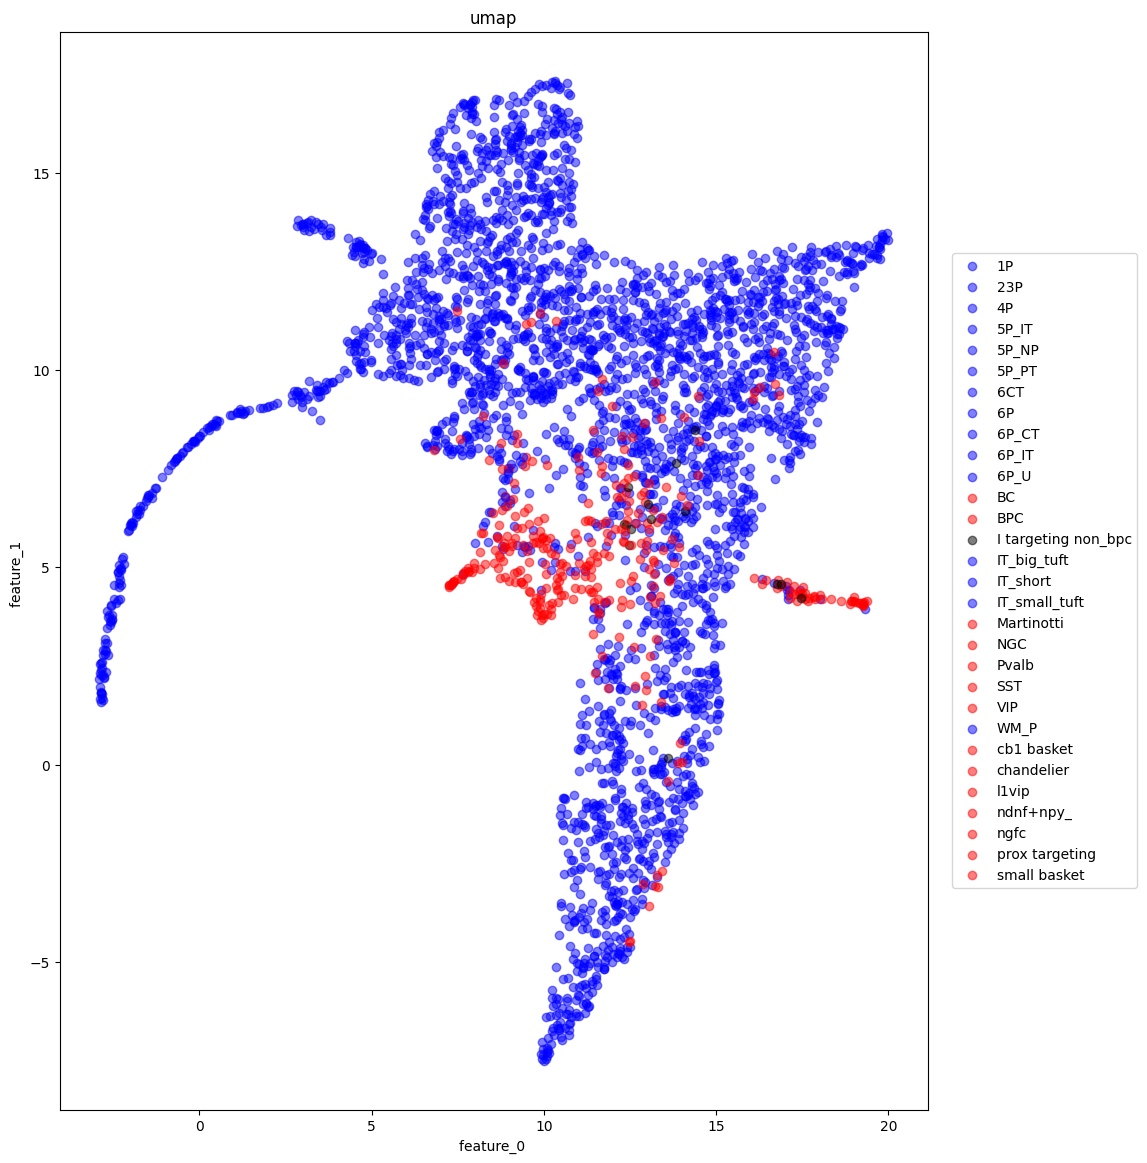

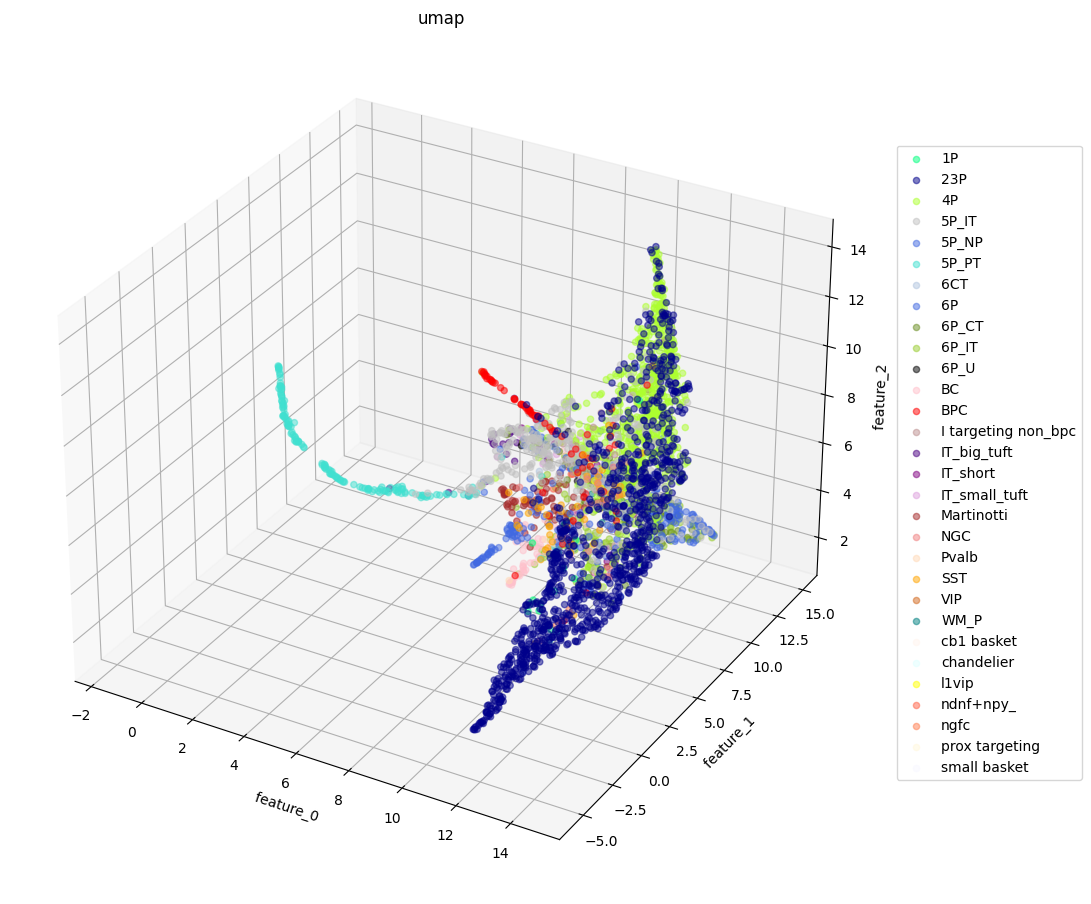

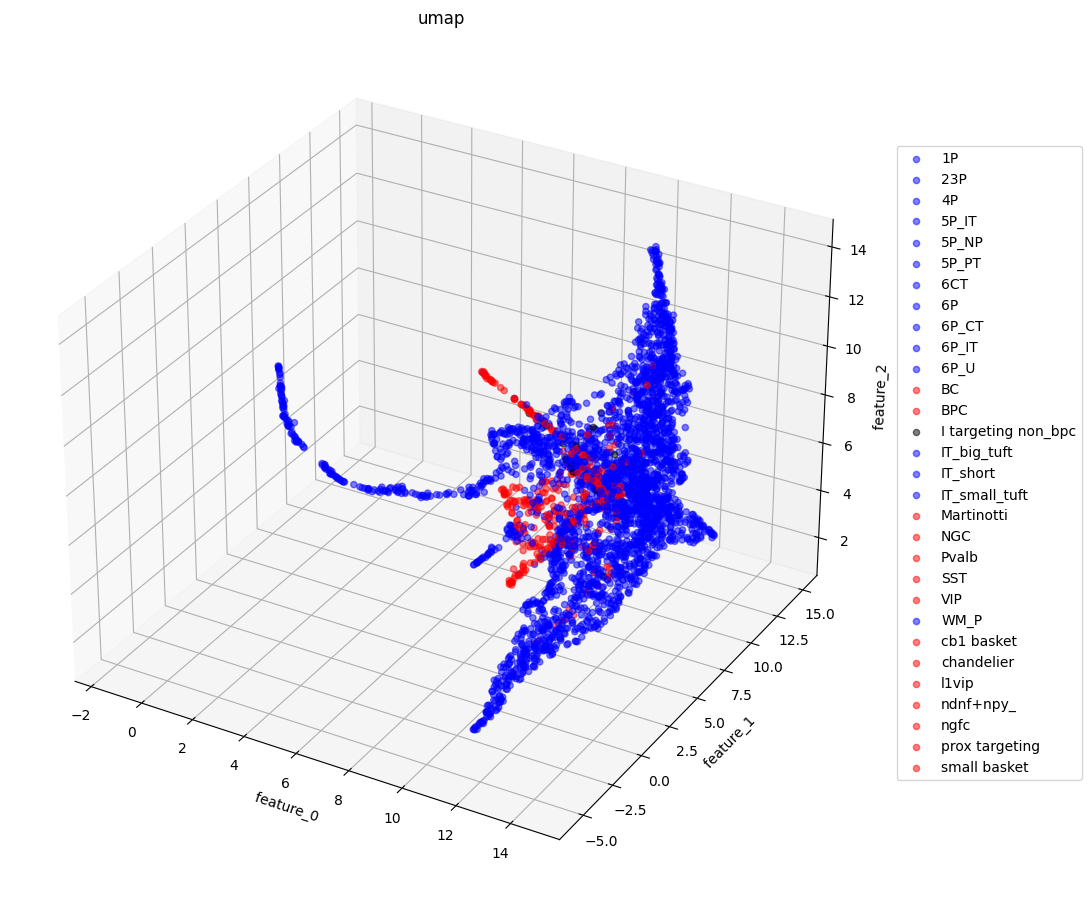

In [64]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "umap",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    min_dist = 0.5,
    #plot_kwargs=dict(use_labels_as_text_to_plot = True)
)

# b) UMAP (0.2)

In [65]:
sys.path.append("/meshAfterParty/meshAfterParty/")
import datajoint_utils as du
import cell_type_utils as ctu

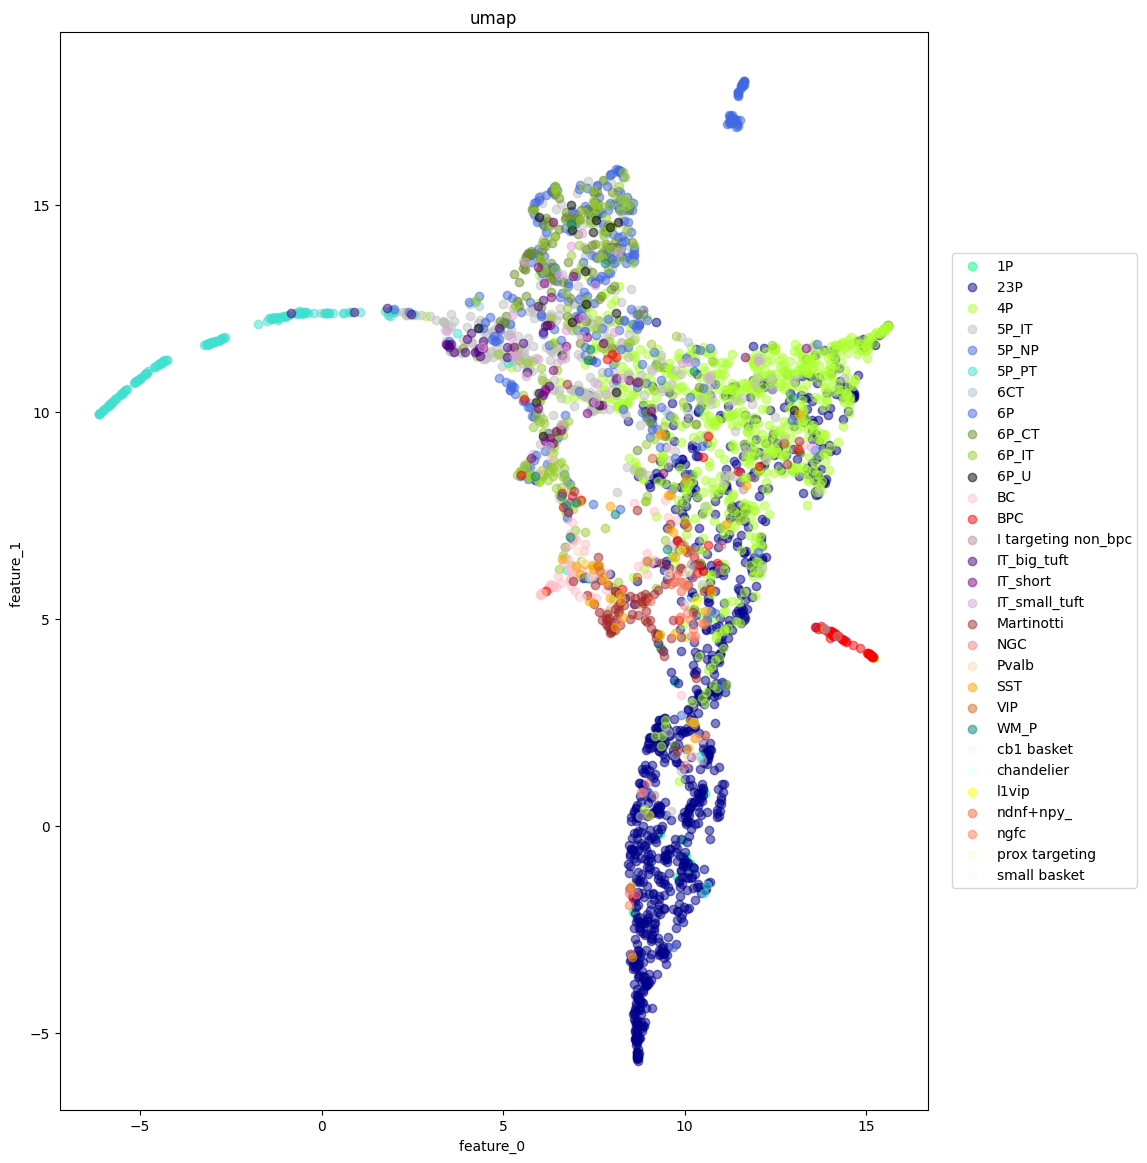

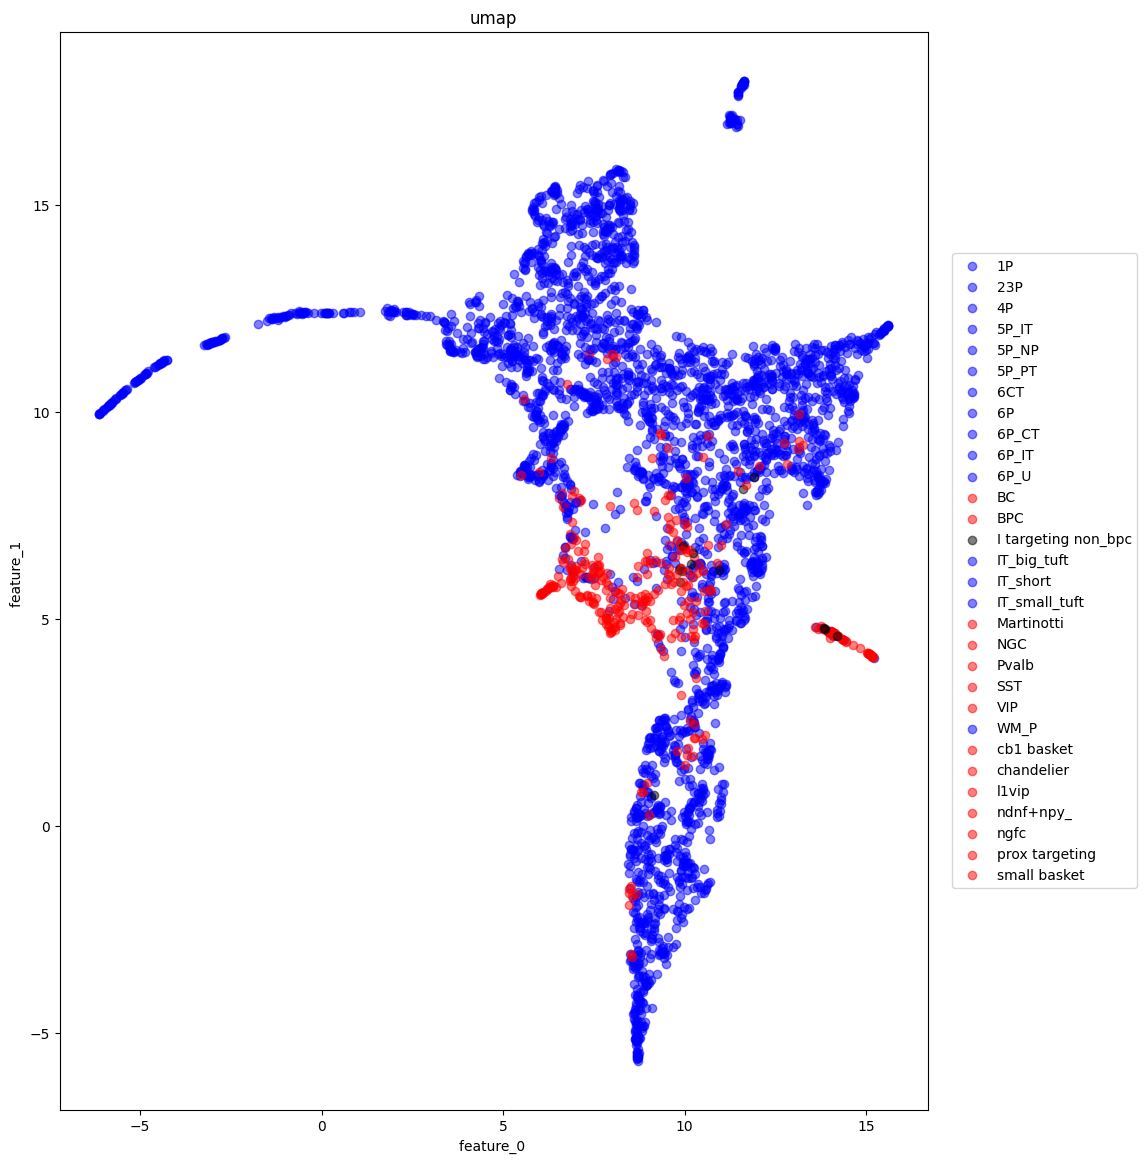

Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x7fa2590adae8>
Traceback (most recent call last):
  File "/usr/lib/python3.6/weakref.py", line 109, in remove
    def remove(wr, selfref=ref(self), _atomic_removal=_remove_dead_weakref):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [66]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "umap",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    min_dist = 0.2,
)

# tsne

In [ ]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "tsne",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    #min_dist = 0.2,
)

# Running a Classification and then a confusion matrix

In [67]:
embedding_df

0         1         2         3         4         5         6  \
0     0.004525  0.003567  0.037424  0.186780  0.290578  0.051720  0.007324   
1     0.005089  0.011481  0.168869  0.199569  0.061848  0.009174  0.003340   
2     0.003468  0.004752  0.093176  0.118221  0.099127  0.004794  0.024890   
3     0.000993  0.000514  0.001491  0.005057  0.044134  0.011207  0.029682   
4     0.003348  0.071326  0.145037  0.057369  0.006171  0.003224  0.000199   
...        ...       ...       ...       ...       ...       ...       ...   
3416  0.002640  0.004873  0.055549  0.508888  0.102675  0.016720  0.002034   
3417  0.001603  0.022503  0.076357  0.021216  0.007878  0.003054  0.001790   
3418  0.000517  0.000088  0.000082  0.015884  0.176495  0.301368  0.002194   
3419  0.002234  0.003464  0.012344  0.025744  0.051280  0.031134  0.012667   
3420  0.000797  0.001050  0.021476  0.126374  0.009408  0.023018  0.000014   

             7         8         9  ...        23        24        25  \
0     0.013955  0.053120  0.045010  ...  0.004706  0.005137  0.003087   
1     0.008245  0.051011  0.025418  ...  0.009363  0.008692  0.014036   
2     0.051738  0.339343  0.073536  ...  0.012702  0.008718  0.001735   
3     0.005042  0.033005  0.021698  ...  0.001115  0.008305  0.000328   
4     0.005874  0.039849  0.002546  ...  0.063917  0.053151  0.003856   
...        ...       ...       ...  ...       ...       ...       ...   
3416  0.005591  0.020300  0.019002  ...  0.003727  0.006193  0.008088   
3417  0.000448  0.001884  0.000278  ...  0.010019  0.010351  0.004786   
3418  0.007159  0.029486  0.006212  ...  0.000524  0.003588  0.000298   
3419  0.004222  0.019564  0.005362  ...  0.011594  0.024394  0.002790   
3420  0.003298  0.017138  0.005446  ...  0.004471  0.003254  0.005854   

            26        27        28        29        30        31  cell_type  
0     0.005381  0.004612  0.002362  0.002725  0.004546  0.005042         4P  
1     0.006036  0.008632  0.023772  0.013941  0.005633  0.005627        23P  
2     0.004112  0.005063  0.002356  0.007011  0.002766  0.003943      5P_IT  
3     0.001181  0.000375  0.000247  0.000050  0.002149  0.001109   IT_short  
4     0.003903  0.012688  0.082306  0.011821  0.002641  0.003664        23P  
...        ...       ...       ...       ...       ...       ...        ...  
3416  0.003078  0.003518  0.007261  0.009488  0.003024  0.002900         4P  
3417  0.001906  0.003728  0.023935  0.009682  0.002867  0.001810     Unsure  
3418  0.000624  0.000267  0.000311  0.000092  0.001176  0.000584      5P_NP  
3419  0.002683  0.002787  0.002729  0.000962  0.005971  0.002549         6P  
3420  0.000946  0.007819  0.007277  0.000630  0.000758  0.000889        BPC  

[3421 rows x 33 columns]

In [68]:
import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0         1         2         3         4         5         6  \
0     0.004525  0.003567  0.037424  0.186780  0.290578  0.051720  0.007324   
1     0.005089  0.011481  0.168869  0.199569  0.061848  0.009174  0.003340   
2     0.003468  0.004752  0.093176  0.118221  0.099127  0.004794  0.024890   
3     0.000993  0.000514  0.001491  0.005057  0.044134  0.011207  0.029682   
4     0.003348  0.071326  0.145037  0.057369  0.006171  0.003224  0.000199   
...        ...       ...       ...       ...       ...       ...       ...   
3415  0.004594  0.007057  0.299191  0.123986  0.058135  0.019056  0.002627   
3416  0.002640  0.004873  0.055549  0.508888  0.102675  0.016720  0.002034   
3418  0.000517  0.000088  0.000082  0.015884  0.176495  0.301368  0.002194   
3419  0.002234  0.003464  0.012344  0.025744  0.051280  0.031134  0.012667   
3420  0.000797  0.001050  0.021476  0.126374  0.009408  0.023018  0.000014   

             7         8         9  ...        24        25        26  \
0     0.013955  0.053120  0.045010  ...  0.005137  0.003087  0.005381   
1     0.008245  0.051011  0.025418  ...  0.008692  0.014036  0.006036   
2     0.051738  0.339343  0.073536  ...  0.008718  0.001735  0.004112   
3     0.005042  0.033005  0.021698  ...  0.008305  0.000328  0.001181   
4     0.005874  0.039849  0.002546  ...  0.053151  0.003856  0.003903   
...        ...       ...       ...  ...       ...       ...       ...   
3415  0.007994  0.031462  0.014860  ...  0.004776  0.018258  0.005454   
3416  0.005591  0.020300  0.019002  ...  0.006193  0.008088  0.003078   
3418  0.007159  0.029486  0.006212  ...  0.003588  0.000298  0.000624   
3419  0.004222  0.019564  0.005362  ...  0.024394  0.002790  0.002683   
3420  0.003298  0.017138  0.005446  ...  0.003254  0.005854  0.000946   

            27        28        29        30        31  cell_type  \
0     0.004612  0.002362  0.002725  0.004546  0.005042         4P   
1     0.008632  0.023772  0.013941  0.005633  0.005627        23P   
2     0.005063  0.002356  0.007011  0.002766  0.003943      5P_IT   
3     0.000375  0.000247  0.000050  0.002149  0.001109   IT_short   
4     0.012688  0.082306  0.011821  0.002641  0.003664        23P   
...        ...       ...       ...       ...       ...        ...   
3415  0.012380  0.015103  0.010760  0.004797  0.005181         4P   
3416  0.003518  0.007261  0.009488  0.003024  0.002900         4P   
3418  0.000267  0.000311  0.000092  0.001176  0.000584      5P_NP   
3419  0.002787  0.002729  0.000962  0.005971  0.002549         6P   
3420  0.007819  0.007277  0.000630  0.000758  0.000889        BPC   

      cell_type_predicted  
0                   5P_IT  
1                      4P  
2                      6P  
3                   6P_IT  
4                     BPC  
...                   ...  
3415                  23P  
3416                   4P  
3418                5P_NP  
3419                6P_IT  
3420                  BPC  

[3399 rows x 34 columns]

In [69]:
accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
accuracy

0.6025301559282141

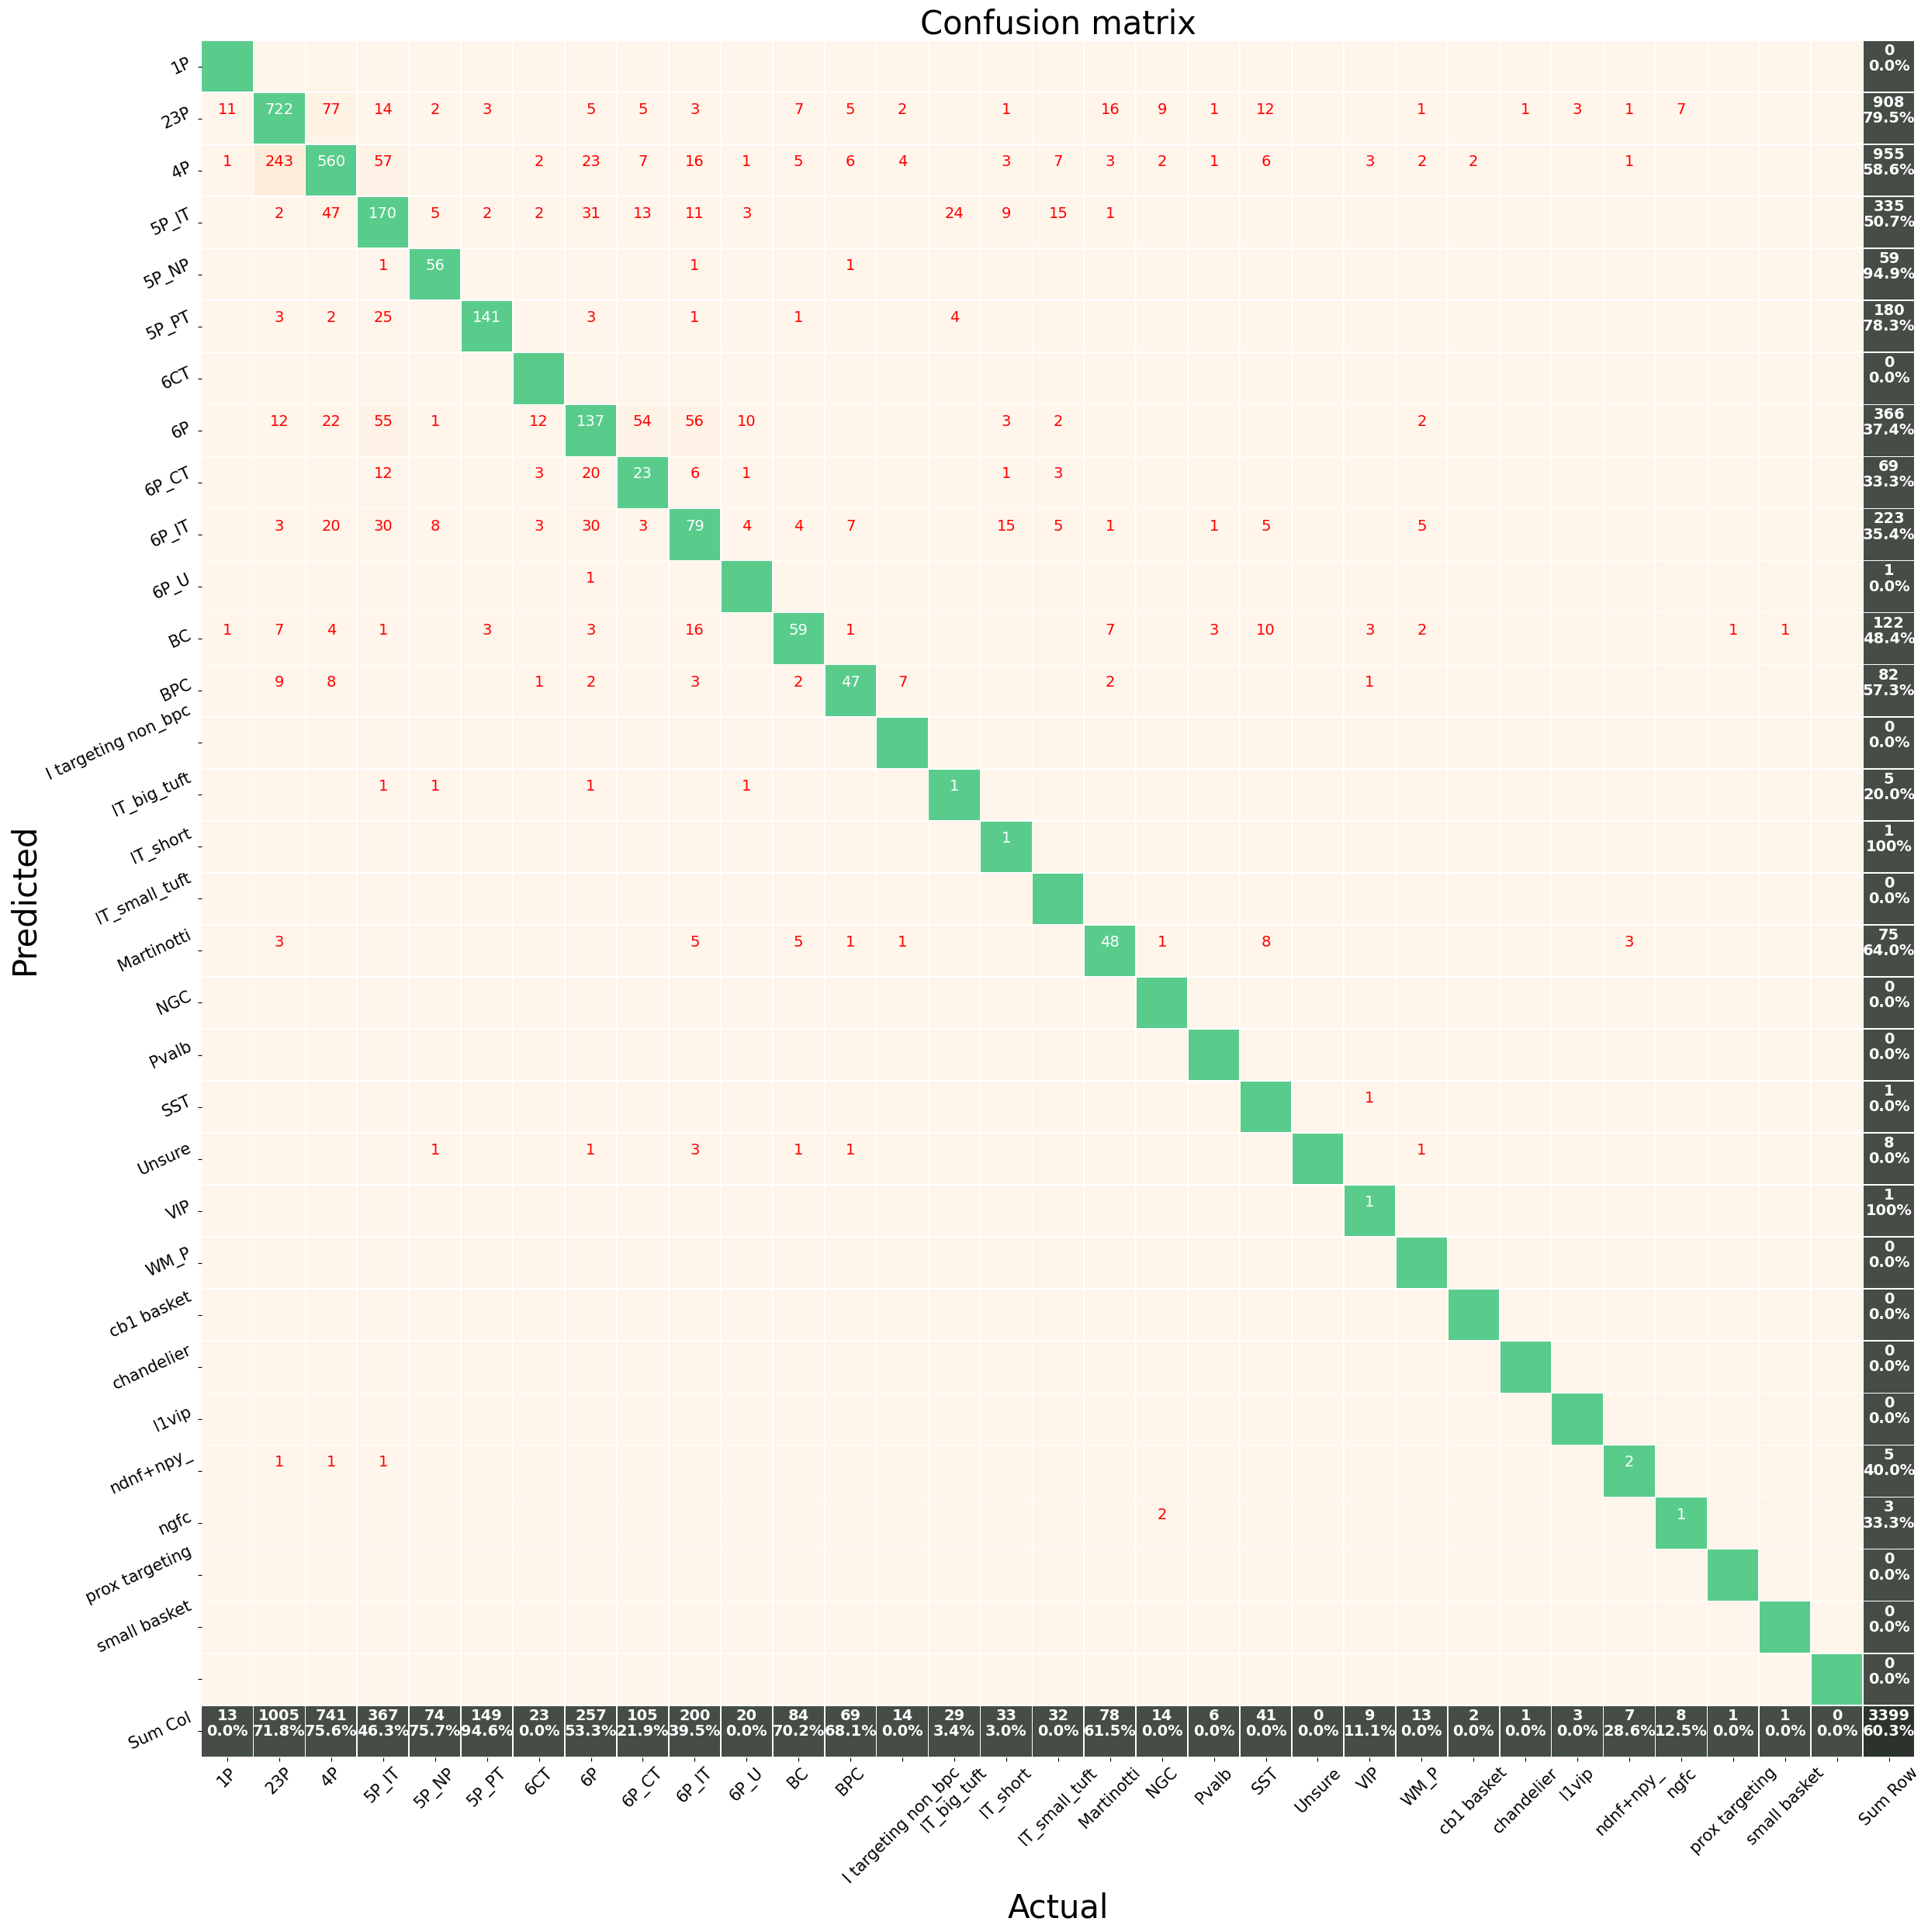

In [70]:
import statistics_visualizations as sviz
sviz.plot_pretty_confusion_matrix(
    y_true = df_labeled["cell_type"],
    y_pred = df_labeled["cell_type_predicted"],
    labels = list(cell_type_map.keys()),
    figsize=(25,25),
    cell_fontsize = 14,
    ticklabel_fontsize=15)

# Confusion matrix of EI

In [71]:
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]
df_labeled

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0         1         2         3         4         5         6  \
0     0.004525  0.003567  0.037424  0.186780  0.290578  0.051720  0.007324   
1     0.005089  0.011481  0.168869  0.199569  0.061848  0.009174  0.003340   
2     0.003468  0.004752  0.093176  0.118221  0.099127  0.004794  0.024890   
3     0.000993  0.000514  0.001491  0.005057  0.044134  0.011207  0.029682   
4     0.003348  0.071326  0.145037  0.057369  0.006171  0.003224  0.000199   
...        ...       ...       ...       ...       ...       ...       ...   
3415  0.004594  0.007057  0.299191  0.123986  0.058135  0.019056  0.002627   
3416  0.002640  0.004873  0.055549  0.508888  0.102675  0.016720  0.002034   
3418  0.000517  0.000088  0.000082  0.015884  0.176495  0.301368  0.002194   
3419  0.002234  0.003464  0.012344  0.025744  0.051280  0.031134  0.012667   
3420  0.000797  0.001050  0.021476  0.126374  0.009408  0.023018  0.000014   

             7         8         9  ...        26        27        28  \
0     0.013955  0.053120  0.045010  ...  0.005381  0.004612  0.002362   
1     0.008245  0.051011  0.025418  ...  0.006036  0.008632  0.023772   
2     0.051738  0.339343  0.073536  ...  0.004112  0.005063  0.002356   
3     0.005042  0.033005  0.021698  ...  0.001181  0.000375  0.000247   
4     0.005874  0.039849  0.002546  ...  0.003903  0.012688  0.082306   
...        ...       ...       ...  ...       ...       ...       ...   
3415  0.007994  0.031462  0.014860  ...  0.005454  0.012380  0.015103   
3416  0.005591  0.020300  0.019002  ...  0.003078  0.003518  0.007261   
3418  0.007159  0.029486  0.006212  ...  0.000624  0.000267  0.000311   
3419  0.004222  0.019564  0.005362  ...  0.002683  0.002787  0.002729   
3420  0.003298  0.017138  0.005446  ...  0.000946  0.007819  0.007277   

            29        30        31  cell_type  cell_type_predicted  \
0     0.002725  0.004546  0.005042         4P                5P_IT   
1     0.013941  0.005633  0.005627        23P                   4P   
2     0.007011  0.002766  0.003943      5P_IT                   6P   
3     0.000050  0.002149  0.001109   IT_short                6P_IT   
4     0.011821  0.002641  0.003664        23P                  BPC   
...        ...       ...       ...        ...                  ...   
3415  0.010760  0.004797  0.005181         4P                  23P   
3416  0.009488  0.003024  0.002900         4P                   4P   
3418  0.000092  0.001176  0.000584      5P_NP                5P_NP   
3419  0.000962  0.005971  0.002549         6P                6P_IT   
3420  0.000630  0.000758  0.000889        BPC                  BPC   

       e_i_label  e_i_predicted  
0     excitatory     excitatory  
1     excitatory     excitatory  
2     excitatory     excitatory  
3     excitatory     excitatory  
4     excitatory     inhibitory  
...          ...            ...  
3415  excitatory     excitatory  
3416  excitatory     excitatory  
3418  excitatory     excitatory  
3419  excitatory     excitatory  
3420  inhibitory     inhibitory  

[3399 rows x 36 columns]

In [72]:
df_labeled_filt = df_labeled.query("e_i_label != 'unknown'")

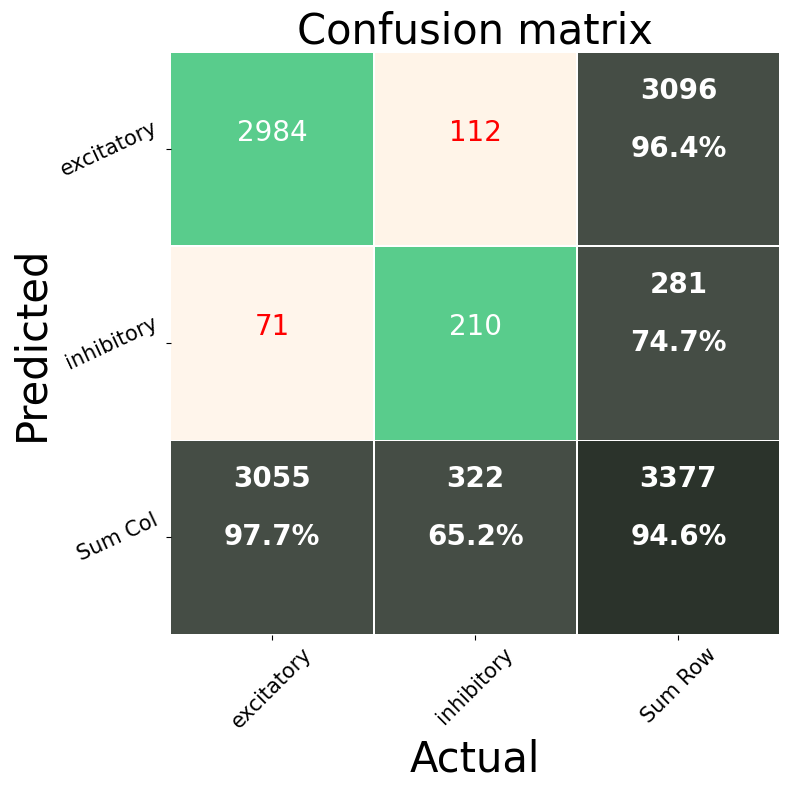

In [73]:
import statistics_visualizations as sviz
sviz.plot_pretty_confusion_matrix(
    y_true = df_labeled["e_i_label"],
    y_pred = df_labeled["e_i_predicted"],
    labels = list(df_labeled_filt["e_i_label"].unique()),
    figsize=(8,8),
    #cell_fontsize = 15,
    #ticklabel_fontsize=15
)

# Computing the Test Accuracy

In [74]:
all_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle = False)
all_data_loader

model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    
    X,y = data
    X = X.to(device)
    y = y.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(X)

    out_array = out.detach().cpu().numpy()
    out_labels = y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]

accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
print(f"cell_type_fine test accuracy: {accuracy}")
accuracy = len(df_labeled.query("e_i_label == e_i_predicted"))/len(df_labeled)
print(f"e_i_label test accuracy: {accuracy}")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cell_type_fine test accuracy: 0.5879765395894428
e_i_label test accuracy: 0.9369501466275659


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [75]:
all_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle = False)
all_data_loader

model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    
    X,y = data
    X = X.to(device)
    y = y.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(X)

    out_array = out.detach().cpu().numpy()
    out_labels = y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]

accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
print(f"cell_type_fine test accuracy: {accuracy}")
accuracy = len(df_labeled.query("e_i_label == e_i_predicted"))/len(df_labeled)
print(f"e_i_label test accuracy: {accuracy}")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cell_type_fine test accuracy: 0.5846833578792342
e_i_label test accuracy: 0.9396170839469808


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
